In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import spacy
import sklearn
import kaggle 
import matplotlib.pyplot as plt #plot package
import wordcloud #will use for the word cloud plot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  

In [2]:
kaggle.api.authenticate()
!kaggle datasets list -s 'sentiment-analysis-for-mental-health'

ref                                                             title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
suchintikasarkar/sentiment-analysis-for-mental-health           Sentiment Analysis for Mental Health                 11587194  2024-07-05 13:58:31.213000          18038        206  1.0              
bhavikjikadara/mental-health-dataset                            Mental Health Dataset                                 2048887  2024-03-18 06:05:16.487000          17469        146  1.0              
reihanenamdari/mental-health-corpus                             Mental Health Corpus                                  4971088  2023-01-04 01:56:41.113000           6218         79  1.0              
miche

No se pudo analizar el valor especificado en una clave del Registro de ejecuci�n autom�tica.


In [3]:
# !kaggle datasets download -d suchintikasarkar/sentiment-analysis-for-mental-health -p ../data
# import zipfile
# import os

# zip_path = "../data/sentiment-analysis-for-mental-health.zip"
# extract_dir = "../data/mental_health"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

In [4]:
df_mh = pd.read_csv("../data/mental_health/Combined Data.csv")
df_mh.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
df_mh.drop(columns=['Unnamed: 0'], inplace=True)
df_mh

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [6]:
df_mh['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [7]:
df_mh.isna().sum()

statement    362
status         0
dtype: int64

In [8]:
df_mh[df_mh.statement.isna() == True].status.value_counts()

status
Personality disorder    124
Bipolar                 100
Stress                   82
Anxiety                  47
Normal                    8
Suicidal                  1
Name: count, dtype: int64

In this case the category with less data is the one with most missing values. In this case maybe doing undersampling woulkd affect the model performance. However I will try this naive apporach to see how it performs. and then I will do other inabalanced data approaches.

In [9]:
df_mh_unproceesed = df_mh.copy()
df_mh.dropna(inplace=True)
df_mh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


## Preproccessing

I will first try to handle imbalanced data with under-sampling.

In [10]:
seed = 200
min_samples= 1077 
df_normal = df_mh[df_mh.status == 'Normal'].sample(1077,random_state=seed)
df_depression = df_mh[df_mh.status == 'Depression'].sample(1077,random_state=seed)
df_suicidal = df_mh[df_mh.status == 'Suicidal'].sample(1077,random_state=seed)
df_anxiaety = df_mh[df_mh.status == 'Anxiety'].sample(1077,random_state=seed)
df_bipolar = df_mh[df_mh.status == 'Bipolar'].sample(1077,random_state=seed)
df_stress = df_mh[df_mh.status == 'Stress'].sample(1077,random_state=seed)
df_per_dis = df_mh[df_mh.status == 'Personality disorder'].sample(1077,random_state=seed)

In [11]:
df_balanced = pd.concat([df_normal, df_depression, df_suicidal,df_anxiaety,
                         df_bipolar, df_stress,df_per_dis], axis=0)
df_balanced.status.value_counts()

status
Normal                  1077
Depression              1077
Suicidal                1077
Anxiety                 1077
Bipolar                 1077
Stress                  1077
Personality disorder    1077
Name: count, dtype: int64

In [12]:
nlp = spacy.load('en_core_web_sm')
import re
## work in better prerpocessing 
def preprocessing(text):
    """
        This function takes a string and applies the tokenization to remove punctuation, stop words and applies lemmatization 
    """
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    processed_text = [token.lemma_ for token in nlp(text) if not token.is_stop and not token.is_punct and not token.like_url and not token.like_email]
    return ' '.join(processed_text)


In [13]:
print(df_normal.statement[28882])

print(preprocessing(df_normal.statement[28882]))

I debated for ten minutes what I should do. I didn't want to open the message completely and violate her trust that far, so I woke her up (which was a big decision because she loves sleep and has two tests today - I know I'm an asshole but she understands and doesn't want me going crazy while she sleeps), and yeah. That was that. She told the guy she was in a relationship (who doesn't check relationship status on Facebook ffs? ), and thanked him for creating a shitstorm.
debate minute want open message completely violate trust far wake big decision love sleep test today know asshole understand want go crazy sleep yeah tell guy relationship check relationship status facebook ffs thank create shitstorm


In [14]:
df_balanced['proc_statement']=df_balanced.statement.apply(preprocessing)
df_balanced 

,statement,status,proc_statement
5399,HSGSHAHA mabait c sir sub nde,Normal,hsgshaha mabait c sir sub nde
31669,how smart are you?,Normal,smart
41844,maddyva thanks a lot learned a lot of new word...,Normal,maddyva thank lot learn lot new word didn t fi...
1417,"""Whoever sells with two sales in one transacti...",Normal,sell sale transaction low price usury hr abu d...
28882,I debated for ten minutes what I should do. I ...,Normal,debate minute want open message completely vio...
...,...,...,...
51031,am happy but also worried about the warmer wea...,Personality disorder,happy worried warm weather start warm spring c...
51593,"Interview anxiety Hi all,\n\nI’ve been job sea...",Personality disorder,interview anxiety hi i’ve job search august of...
51554,Can you relate to these? I wanna know if you g...,Personality disorder,relate wanna know guy relate point try speak l...
51524,"My friend text me, I managed 1 reply before ig...",Personality disorder,friend text manage reply ignore feel awful p...


In [15]:
df_balanced.drop(columns=['statement'],inplace=True)
target = {"Normal"                :0, 
           "Depression"           :1,
           "Suicidal"             :2,
           "Anxiety"              :3,
           "Bipolar"              :4,
           "Stress"               :5,
           "Personality disorder" :6}
df_balanced['category_num'] = df_balanced.status.map(target)
df_balanced.to_csv('../data/mental_health/preprocessed_mental_health_data.csv')
df_balanced

,status,proc_statement,category_num
5399,Normal,hsgshaha mabait c sir sub nde,0
31669,Normal,smart,0
41844,Normal,maddyva thank lot learn lot new word didn t fi...,0
1417,Normal,sell sale transaction low price usury hr abu d...,0
28882,Normal,debate minute want open message completely vio...,0
...,...,...,...
51031,Personality disorder,happy worried warm weather start warm spring c...,6
51593,Personality disorder,interview anxiety hi i’ve job search august of...,6
51554,Personality disorder,relate wanna know guy relate point try speak l...,6
51524,Personality disorder,friend text manage reply ignore feel awful p...,6


C:\Users\hecma\AppData\Local\Temp\ipykernel_5616\241026556.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0, h_pad=1.0, w_pad=1.0)


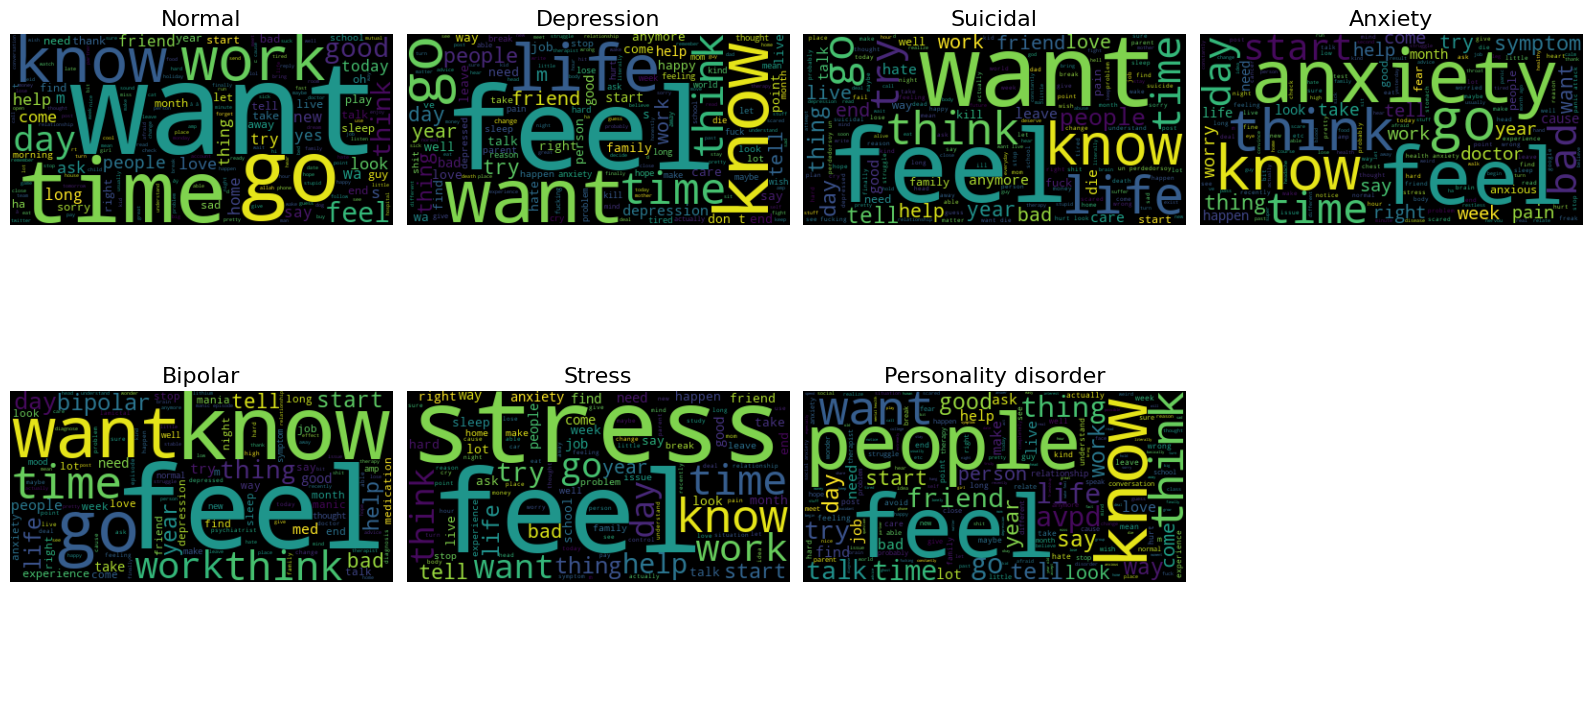

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
axes = axes.flatten()  # Flatten to easily iterate

for i, name in enumerate(target):
    # Generate text for this category
    text = ' '.join(df_balanced[df_balanced.category_num == i].proc_statement)
    # Generate word cloud
    wordcloud = WordCloud(background_color="black")
    wordcloud.generate(text)
    # Plot on subplot
    axes[i].imshow(wordcloud.recolor(colormap='viridis', random_state=17), interpolation='bilinear')
    axes[i].set_title(name, fontsize=16)
    axes[i].axis('off')
    
# Hide the last (8th) subplot if unused
if len(target) < len(axes):
    for j in range(len(target), len(axes)):
        axes[j].axis('off')
plt.tight_layout(pad=1.0, h_pad=1.0, w_pad=1.0)
plt.show()


# Prediction using ML models 

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced.proc_statement, df_balanced.category_num,
                                                    random_state=seed, 
                                                    test_size=0.2,
                                                    stratify=df_balanced.category_num)


For the vectoprization, I will use bag of n-grams.

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer

clf_nb = Pipeline([
    ('vectorize_n_Grams', CountVectorizer(ngram_range=(1,2))),
    ('Naive Bayes', MultinomialNB())])

clf_nb.fit(X_train,y_train)
y_pred = clf_nb.predict(X_test)
print(classification_report(y_test,y_pred,target_names=target))

                      precision    recall  f1-score   support

              Normal       1.00      0.04      0.07       216
          Depression       0.39      0.47      0.42       216
            Suicidal       0.55      0.62      0.58       216
             Anxiety       0.65      0.80      0.71       215
             Bipolar       0.55      0.82      0.66       215
              Stress       0.79      0.24      0.37       215
Personality disorder       0.53      0.86      0.66       215

            accuracy                           0.55      1508
           macro avg       0.64      0.55      0.50      1508
        weighted avg       0.64      0.55      0.50      1508



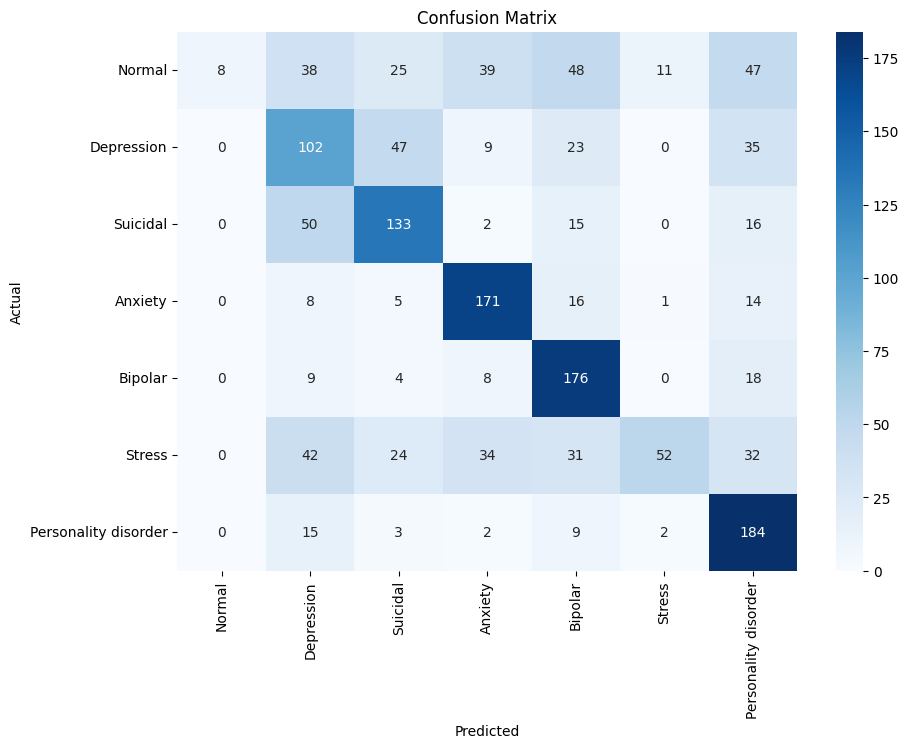

In [19]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

                      precision    recall  f1-score   support

              Normal       0.95      0.18      0.30       216
          Depression       0.47      0.52      0.50       216
            Suicidal       0.57      0.75      0.65       216
             Anxiety       0.68      0.78      0.73       215
             Bipolar       0.66      0.80      0.73       215
              Stress       0.70      0.41      0.52       215
Personality disorder       0.59      0.87      0.70       215

            accuracy                           0.61      1508
           macro avg       0.66      0.61      0.59      1508
        weighted avg       0.66      0.61      0.59      1508



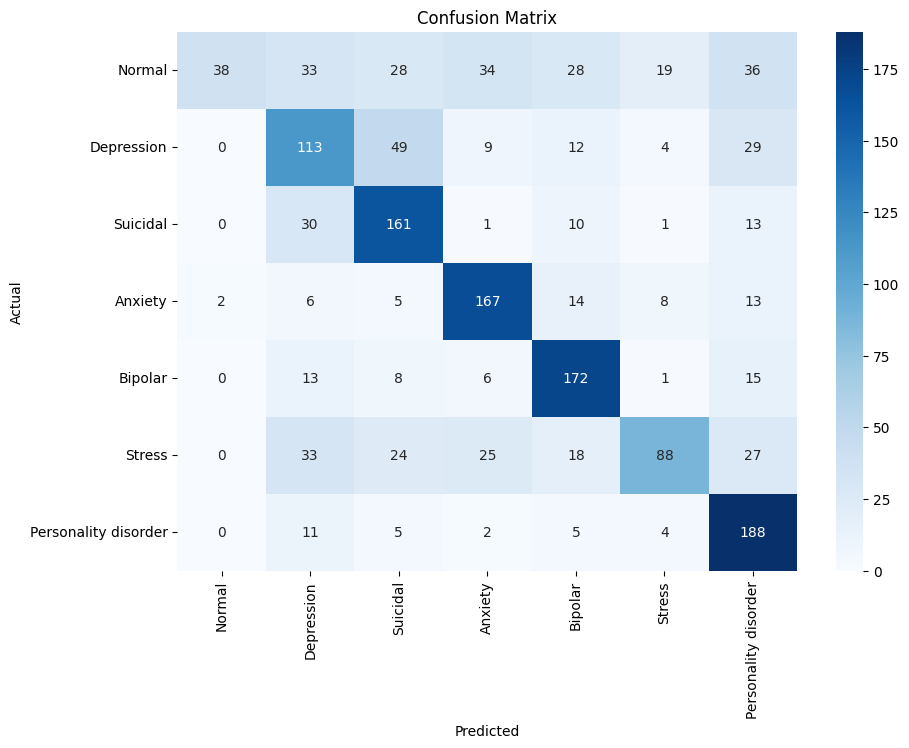

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

clf_nb_tfid = Pipeline([
    ('vectorize_TFID', TfidfVectorizer()), # I will try again with TFIDF method to see the difference in performance 
    ('Naive Bayes', MultinomialNB())])

clf_nb_tfid.fit(X_train,y_train)
y_pred = clf_nb_tfid.predict(X_test)
print(classification_report(y_test,y_pred,target_names=target))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

                      precision    recall  f1-score   support

              Normal       0.77      0.76      0.77       216
          Depression       0.51      0.45      0.48       216
            Suicidal       0.60      0.69      0.64       216
             Anxiety       0.78      0.84      0.81       215
             Bipolar       0.84      0.80      0.82       215
              Stress       0.67      0.60      0.64       215
Personality disorder       0.78      0.80      0.79       215

            accuracy                           0.71      1508
           macro avg       0.71      0.71      0.71      1508
        weighted avg       0.71      0.71      0.71      1508



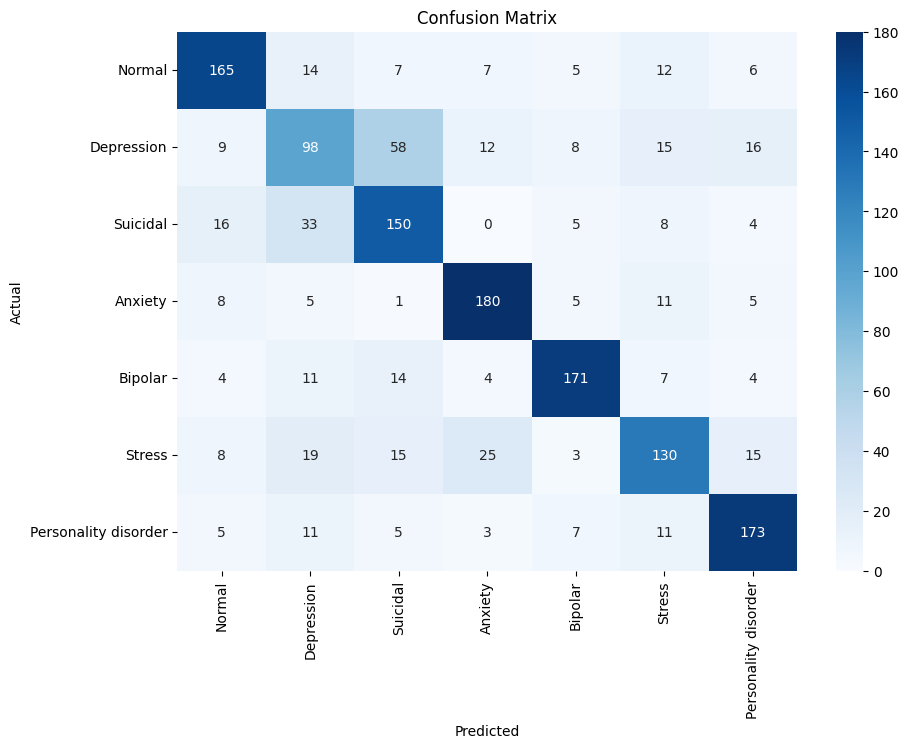

In [21]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Pipeline with TFIDF + SVM
clf_SVC_tfid = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', LinearSVC())])
# setting some hyperparameter selction for fine tuning, I already saw that TFIDF works better for this case 
svc_param_grid = {
    'classifier__penalty': ['l2'],  # 'l1' only with dual=False
    'classifier__C': np.linspace(10, 100, num=8),
    'classifier__max_iter': [500,1000]}


# GridSearch with correct param names
best_params = GridSearchCV(clf_SVC_tfid, svc_param_grid, cv=5, n_jobs=-1)
best_params.fit(X_train, y_train)
y_pred = best_params.predict(X_test)

print(classification_report(y_test,y_pred,target_names=target))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [22]:
best_params.best_params_

{'classifier__C': np.float64(10.0),
 'classifier__max_iter': 500,
 'classifier__penalty': 'l2'}

In [23]:
from xgboost import XGBClassifier

# Pipeline
clf_XGB_tfid = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', XGBClassifier(tree_method='hist', random_state=101))])

# Parameter Grid
XGB_param_grid = {
    'classifier__learning_rate': [0.1, 0.5],
    'classifier__max_depth': [5, 7],
    'classifier__n_estimators': [200]}

# Grid Search
best_params = GridSearchCV(clf_XGB_tfid, XGB_param_grid, cv=5, n_jobs=-1)
best_params.fit(X_train, y_train)

# Predictions
y_pred = best_params.predict(X_test)


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
                      precision    recall  f1-score   support

              Normal       0.67      0.93      0.78       216
          Depression       0.52      0.44      0.47       216
            Suicidal       0.56      0.62      0.59       216
             Anxiety       0.79      0.74      0.77       215
             Bipolar       0.89      0.77      0.83       215
              Stress       0.66      0.62      0.64       215
Personality disorder       0.77      0.69      0.73       215

            accuracy                           0.69      1508
           macro avg       0.69      0.69      0.69      1508
        weighted avg       0.69      0.69      0.69      1508



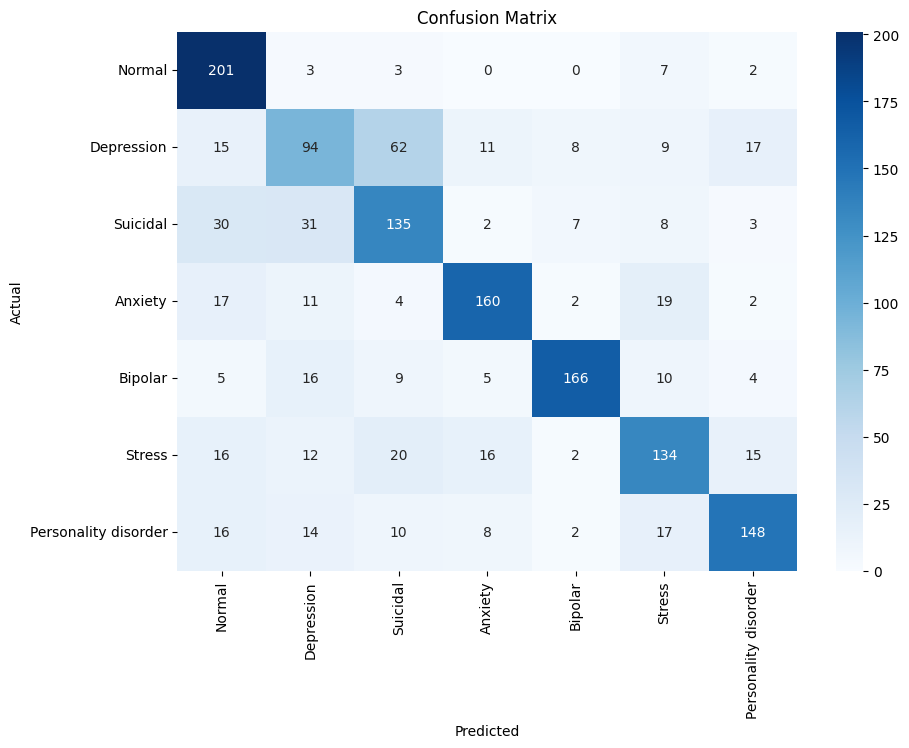

In [24]:

# Report
print("Best Parameters:", best_params.best_params_)
print(classification_report(y_test, y_pred, target_names=list(target.keys())))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Save the best model
import joblib
import os
try:
    joblib.dump(best_params, '../models/xgb_mental_health_model.pkl')
except :
    print("Models directory does not exist, creating it.")
    os.mkdir("../models")
    joblib.dump(best_params, '../models/xgb_mental_health_model.pkl')

Models directory does not exist, creating it.


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
                      precision    recall  f1-score   support

              Normal       0.72      0.92      0.80       216
          Depression       0.54      0.45      0.49       216
            Suicidal       0.53      0.67      0.59       216
             Anxiety       0.79      0.75      0.77       215
             Bipolar       0.88      0.77      0.82       215
              Stress       0.66      0.60      0.63       215
Personality disorder       0.77      0.69      0.73       215

            accuracy                           0.69      1508
           macro avg       0.70      0.69      0.69      1508
        weighted avg       0.70      0.69      0.69      1508



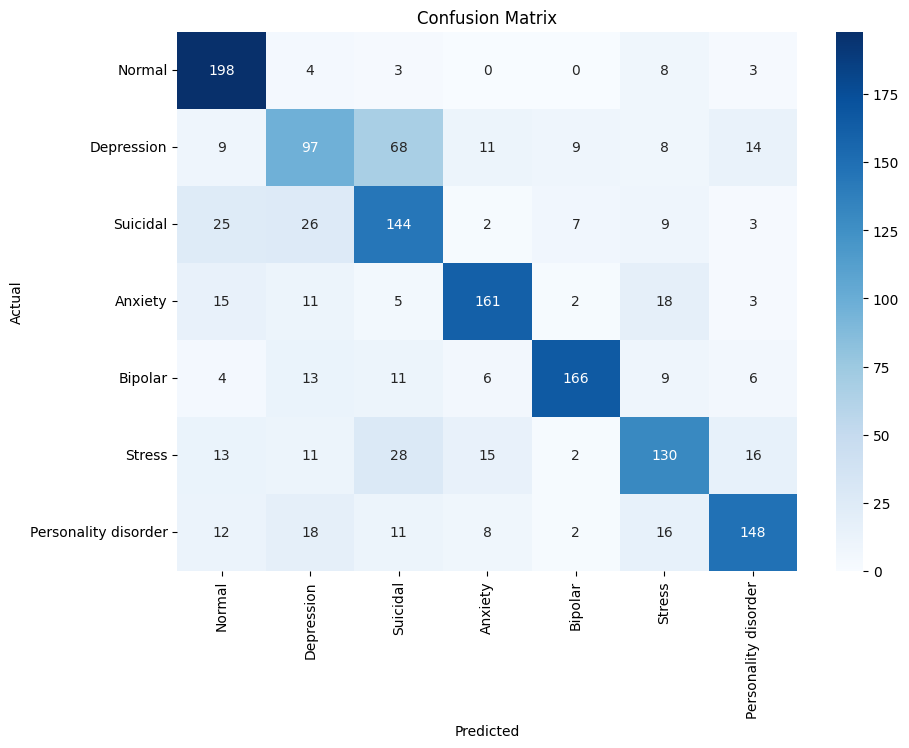

In [54]:
from sklearn.utils.class_weight import compute_sample_weight

# Define class weights
class_weights = {
    0: 0.8,  # Normal
    1: 1.3, # Depression
    2: 1.5, # Suicidal
    3: 1.2, # Anxiety 
    4: 1.2, # Bipolar
    5: 1.2, # Stress
    6: 1.2, # Personality disorder
}

# Compute sample weights
sample_weights = compute_sample_weight(class_weight=class_weights, y=y_train)

# Vectorize manually
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

xgb_best_params = {k.replace("classifier__", ""): v for k, v in best_params.best_params_.items()}

# Instantiate classifier with best params
classifier = XGBClassifier(**xgb_best_params)

# Fit with sample weights
classifier.fit(X_train_vec, y_train, sample_weight=sample_weights)

# Predict
y_pred = classifier.predict(X_test_vec)

# Report
print("Best Parameters:", best_params.best_params_)
print(classification_report(y_test, y_pred, target_names=list(target.keys())))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()